<a href="https://colab.research.google.com/github/BhagwatPriyanka/Fraudulent-Transaction-Prediction/blob/main/Fraudulent_Transaction_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Import ,Cleaning , Visualization -

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
df = pd.read_csv('Fraud.csv')

In [70]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


As we can see, the column names are inconsistent, therefore we'll update them to be more consistent.

In [71]:
df = df.rename(columns={'nameOrig':'nameorig','oldbalanceOrg':'oldbalanceorig','newbalanceOrig':'newbalanceorig','nameDest':'namedest'
    ,'oldbalanceDest':'oldbalancedest','newbalanceDest':'newbalancedest'})
df.columns

Index(['step', 'type', 'amount', 'nameorig', 'oldbalanceorig',
       'newbalanceorig', 'namedest', 'oldbalancedest', 'newbalancedest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

**1. Data cleaning including missing values, outliers and multi-collinearity**


In [72]:
df.isnull().sum()  

step              0
type              0
amount            0
nameorig          0
oldbalanceorig    0
newbalanceorig    0
namedest          0
oldbalancedest    0
newbalancedest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [73]:
df = df.dropna()

In [74]:
df.isnull().sum()  

step              0
type              0
amount            0
nameorig          0
oldbalanceorig    0
newbalanceorig    0
namedest          0
oldbalancedest    0
newbalancedest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

So we can see there are missing values present in columns 'isFraud', 'isFlaggedFraud', 'newbalancedest'. But there can be 0 values in some variables.

Checking for outliers is pointless because the bank balance might be any real number value, hence there is no way to scale it. And it is a classification problem so In classification problem we wont use outliers.

**Multi-collinearity -**

In [75]:
df1 = df.copy(deep = 'true')
df1['type']=df1['type'].map({'PAYMENT':1 ,'TRANSFER':2, 'CASH_OUT':3, 'DEBIT':4, 'CASH_IN':5})
df1 = df1.drop(columns = ['nameorig','namedest','isFraud','isFlaggedFraud'])
df1.head()

,step,type,amount,oldbalanceorig,newbalanceorig,oldbalancedest,newbalancedest
0,1,1,9839.64,170136.0,160296.36,0.0,0.0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0
2,1,2,181.00,181.0,0.00,0.0,0.0
3,1,3,181.00,181.0,0.00,21182.0,0.0
4,1,1,11668.14,41554.0,29885.86,0.0,0.0


In [76]:
#calculating VIf to check the MUlti-collinearity between variables -

vif_data = pd.DataFrame()                         
vif_data["feature"] = df1.columns
vif_data["VIF"] = [variance_inflation_factor(df1.values, i)
                          for i in range(len(df1.columns))]
print(vif_data)

          feature         VIF
0            step    2.466060
1            type    3.251976
2          amount    4.129854
3  oldbalanceorig  501.282300
4  newbalanceorig  508.906801
5  oldbalancedest   73.377939
6  newbalancedest   84.656570


As can be seen, both oldbalance and newbalance have very high VIF values, indicating that they are highly connected. This is to be expected, given the transaction alters their values. As a result, combining these two characteristics results in a model with high multicollinearity.

**1. Which type of transactions are fraud using isFraud -**


Two flags are present. IsFraud is the signal that indicates genuine fraud transactions, whereas isFlaggedFraud is the indicator that the system stops transactions owing to certain thresholds being triggered.

In [77]:
print('Type of transaction which are fraud:{}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

fraud_transfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
fraud_cashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
 

print('number of transfer are fraud :{}'.format(len(fraud_transfer)))
print('number of cashout are fraud :{}'.format(len(fraud_cashout)))

Type of transaction which are fraud:['TRANSFER', 'CASH_OUT']
number of transfer are fraud :4097
number of cashout are fraud :4116


**2. Analysis on isFlaggedFraud variable -**


isFlaggedFraud = The business strategy strives to control large transfers from one account to another and flags any attempts that are considered illegal. An attempt to transfer more than 200.000 in a single transaction is considered illegal in this dataset.

In [78]:
amount_flagfraud0 = list(df.loc[(df.isFlaggedFraud == 0) ].amount.values)
amount_flagfraud1 = list(df.loc[(df.isFlaggedFraud == 1) ].amount.values)

print('minimum amount transfer where isFlaggedFraud is 1 = {}'.format(min(amount_flagfraud1)))
print('maximum amount transfer where isFlaggedFraud is 0 = {}'.format(max(amount_flagfraud0)))
print('Number of isFlaggedFraud == 1 : {}'.format(len(list(df.loc[df.isFlaggedFraud ==1 ].isFlaggedFraud.values))))

minimum amount transfer where isFlaggedFraud is 1 = 353874.22
maximum amount transfer where isFlaggedFraud is 0 = 92445516.64
Number of isFlaggedFraud == 1 : 16


The isFlaggedFraud variable is set to 1 when a single transaction has a value of more than 200,000, as shown in the above study. Because the maximum amount transfer in a single transaction is 92445516.64 and there are only three options for isFlaggedFraud, we will simply remove this feature.

**3. Oldblanceorig and newbalanceorig variable -**

Because the transaction is on hold and there is no information available for merchants, multiple newbalancedset and oldbalance dest have 0 values.

In [79]:
print('numebr of recipant who have newbalancedest and oldbalancedest is zero :{}'
      .format(len(df.loc[(df.newbalancedest == 0) & (df.oldbalancedest == 0) ].namedest.values)))

numebr of recipant who have newbalancedest and oldbalancedest is zero :2317282


We can see that there is a transaction amount, but our odlbalanceorig and newbalanceorig are both 0. This doesn't make sense because if there is an amount, it suggests a transaction has occurred. As a result, there must be an error or missing values in these variables.

In [80]:
zero_balance = list(df.loc[(df.oldbalanceorig == 0) & (df.newbalanceorig == 0) & (df.amount != 0)].type.values)

print('Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :{}'.format(len(zero_balance)))

Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :2088969


Let's look at how many merchant accounts there are in originating accounts and whether any of them have fraud transactions.
oldbalanceDest - the receiver of the initial balance before the transaction. Customers beginning with the letter M are not eligible for information (Merchants).

newbalanceDest - following the transaction, the new balance recipient. Customers beginning with the letter M are not eligible for information (Merchants).

In [81]:
print('number of merchants in originator transaction: {}' .format(df.nameorig.str.contains('M').any()))
print('number of merchant acoount in destination where type is Transfer : {}' .format(df.loc[df.type =='TRANSFER'].namedest.str.contains('M').any()))
print('number of merchant acoount in destination where type is cashout : {}' .format(df.loc[df.type =='CASH_OUT'].namedest.str.contains('M').any()))

number of merchants in originator transaction: False
number of merchant acoount in destination where type is Transfer : False
number of merchant acoount in destination where type is cashout : False


There are no Merchant account through Fraud transaction is happen so missing information does not affect while building model


**Data cleaning -**

**3. How did you select variables to be included in the model?**

We can deduce from the foregoing research that fraud only occurs in the 'TRANSFER' and 'CASH OUT' categories. We will delete Variables -[nameorig, namedest, isFlaggedFraud] and choose only those types of payments.


In [82]:
x = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
y = x.isFraud
x = x.drop(['isFraud','isFlaggedFraud','nameorig','namedest'],axis = 1)
x['type']= x['type'].map({'TRANSFER':1,'CASH_OUT':2})

We use np.nan to substitute missing numbers in transactions where newbalanceorig and oldbalanceorig are both zero but the amount is not zero.
There are newblancedest and oldbalancedest values that are equal to zero, but we cannot impute them since they show that a fraud transaction occurred when the amount was not zero.

In [83]:
x.loc[(x.oldbalancedest == 0) & (x.newbalancedest == 0) & (x.amount != 0) ,['oldbalancedest','newbalancedest'] ] = -1 
x.loc[(x.oldbalanceorig == 0) & (x.newbalanceorig == 0) & (x.amount != 0) ,['oldbalanceorig','newbalanceorig'] ] = 0 

#imputing missing values

Feature engineering - We may build two features of error at the origin and destination accounts based on the above analysis, where a non-zero amount is transferred but the oldbalance and newbalance have zero values.

In [84]:
x['errorbalanceorig'] = x.newbalanceorig + x.amount - x.oldbalanceorig   # eg origin- oldbal = 10 ,newbal = 8 ,amount = 2 so, error =  8+2-10 = 0 
x['errorbalancedest'] = x.oldbalancedest + x.amount - x.newbalancedest   #eg - at dest its opposite , old bal = 8 ,new bal = 10 , amount = 2 :error = 8+2-10 = 0

Data visualisation is the most effective technique to see if our data can be classified.

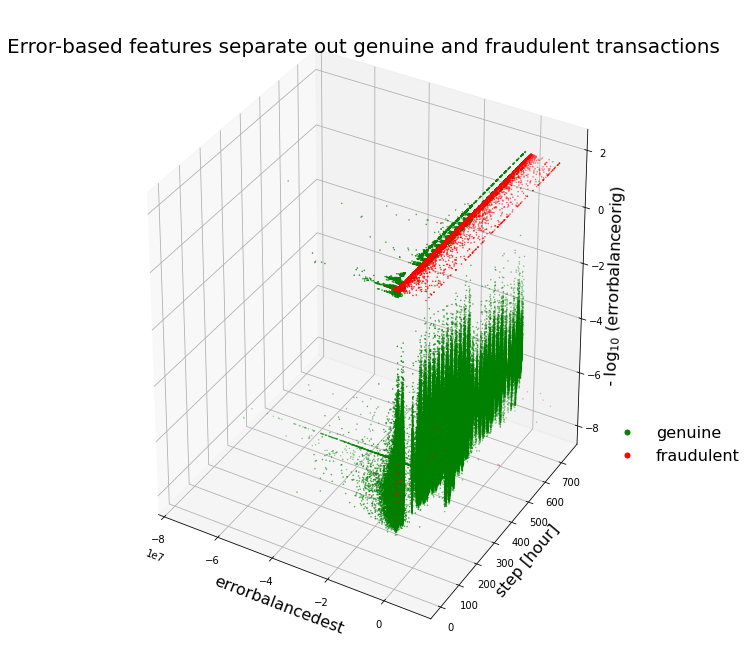

In [85]:
x1 = 'errorbalancedest'                                       
y1 = 'step'
z1= 'errorbalanceorig'
zOffset = 0.02
limit = len(x)

sns.reset_orig() 

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x.loc[y == 0, x1][:limit], x.loc[y == 0, y1][:limit], \
  -np.log10(x.loc[y == 0, z1][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(x.loc[y == 1, x1][:limit], x.loc[y == 1, y1][:limit], \
  -np.log10(x.loc[y == 1, z1][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x1, size = 16); 
ax.set_ylabel(y1 + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z1 + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

As shown in the graphic above, we can separate data utilising our new features.
Checking for data imbalance or skew - Machine learning for predicting fraudulent transactions.

In [86]:
xfraud = x.loc[y==1]
xnotfraud = x.loc[y == 0]

print(len(xfraud))
print(len(xnotfraud))

8213
2762196


Data split in (80:20) ratio between train and test

In [87]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=27)

**4. Demonstrate the performance of the model by using best set of tools.**

I employ the area under the precision-recall curve (AUPRC) instead of the traditional area under the receiver operating characteristic (AUROC) because the data is severely skewed (AUROC). AUPRC will "focus" on how the model handles the 1% positive cases on a dataset with 99 percent negative examples and 1% positive examples. AUPRC will be high if the model handles positive cases well. AUPRC will be low if the model performs badly on positive cases.


**2. Describe your fraud detection model in elaboration.**

Before implementing an ML method, one approach to dealing with imbalanced data is to balance it by deleting the dominant class. Undersampling has the disadvantage that a model trained this manner would not perform well on real-world skewed test data because practically all of the information was removed. A better way would be to oversample the minority class, such as using the 'imblearn' library's synthetic minority oversampling technique (SMOTE). As a result, I experimented with several anomaly detection and supervised learning algorithms. However, I find that employing a machine learning technique based on ensembles of decision trees, which innately performs well on imbalanced data, yields the greatest results on the original dataset. Such methods not only allow us to build a model that can deal with missing values in our data, but they also allow us to speed up the process by using parallel processing. The extreme gradient-boosted (XGBoost) algorithm was utilised among these algorithms. Finally, XGBoost, like numerous other ML algorithms, provides for a higher weighting of the positive class than the negative class —- a setting that accounts for data skew.

In [88]:
weights = (y == 0).sum() / (1.0 * (y == 1).sum())                  #xgb uses the scale_pos_weight to account for highly skewed datset
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights,
                n_jobs = 4)
probabilities = clf.fit(X_train,y_train).predict_proba(X_test)
print('AUPRC = {}'.format(average_precision_score(y_test, probabilities[:, 1])))

AUPRC = 0.9879194331240524


SO AUPRC score is 0.98 means our model performing well on positive (fraudlant transaction) class.


CONCLUSION -

7.What kind of prevention should be adopted while company update its infrastructure?

By focusing more on the payment method types 'Transfer' and 'Cash out,' the company can prevent fraudulent transactions.
Watch for Fraud and Theft Patterns 8.
How would you know if these activities are effective once they've been implemented?
We may retrain and update our model at regular intervals to ensure that it performs well in a variety of fraudulent transactions.